# Slime mold dynamical systems model
In this notebook, we will
- Write a (simple 1D) dynamical systems model of slime mold
- Simulate the slime mold model
    - from known parameters
    - from a Bayesian model with unknown parameters and measurement noise
- Use ChiRho to infer the model parameters from data
- Use ChiRho to infer what would happen if we intervene


In [15]:
# import packages
import pyro
import torch
import numpy as np
from chirho.dynamical.ops import State, simulate
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.handlers import LogTrajectory
from pyro.infer.autoguide import AutoMultivariateNormal
from chirho.observational.handlers import condition
from chirho.dynamical.handlers import StaticBatchObservation
from chirho.dynamical.handlers import StaticIntervention, InterruptionEventLoop

import matplotlib.pyplot as plt
import seaborn as sns

## Slime mold model, simulated from known parameters
Slime mold agents deposit pheromones, which diffuse and dissipate, and slime mold agents move toward higher pheromone concentrations. 

In [44]:
# Define the model
class SimpleSlimeDynamics(pyro.nn.PyroModule):

    # About the model
    # B:                the number of spatial bins
    # D:                the density of slime mold agents
    # P:                the density of pheromones
    # dD/dt:            slime mold follows pheromones
    # dP/dt:            pheromones are deposited by slime mold, then diffuse
    # alpha:            pheromone deposition rate
    # beta_diffuse:     pheromone diffusion rate
    # beta_dissipate:   pheromone dissipation rate
    # r:                slime mold following rate

    def __init__(self, B, alpha, beta_diffuse, beta_dissipate, r):
        super().__init__() # inherit stuff from PyroModule
        self.B = B
        self.alpha = alpha / B
        self.beta_diffuse = beta_diffuse / B
        self.beta_dissipate = beta_dissipate / B
        self.r = r / B

    @pyro.nn.pyro_method
    def diff(self, dstate: State[torch.Tensor], state: State[torch.Tensor]) -> None:
        deposition_term = self.alpha * state["D"]
        diffusion_term = self.beta_diffuse * (torch.roll(state["P"], 1) + torch.roll(state["P"], -1) - 2 * state["P"])
        dissipation_term = -self.beta_dissipate * state["P"]
        # take the log

        pheromone_right = torch.relu(torch.log(torch.roll(state["P"], 1)) - torch.log(state["P"]))
        pheromone_left = torch.relu(torch.log(torch.roll(state["P"], -1)) - torch.log(state["P"]))
        # pheromone_right = torch.relu(torch.roll(state["P"], 1) - state["P"])
        # pheromone_left = torch.relu(torch.roll(state["P"], -1) - state["P"])

        slime_flux_right = self.r * pheromone_right * state["D"]
        slime_flux_left = self.r * pheromone_left * state["D"]

        dstate["D"] = torch.roll(slime_flux_right, -1) - slime_flux_right
        dstate["D"] += torch.roll(slime_flux_left, 1) - slime_flux_left
        dstate["P"] = deposition_term + diffusion_term + dissipation_term


    def forward(self, state: State[torch.Tensor]) -> State[torch.Tensor]:
        dstate = State()
        self.diff(dstate, state)
        return dstate
    
# Plotting function
def show_trajectories(D_trajectory, P_trajectory):
    plt.figure(figsize=(12, 6))

    # Heatmap for D
    plt.subplot(1, 2, 1)
    sns.heatmap(D_trajectory, cmap="viridis", cbar_kws={'label': 'Slime mold concentration'})
    plt.title('Heatmap of Slime Mold Density (D) over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Spatial location')

    # Heatmap for P
    plt.subplot(1, 2, 2)
    sns.heatmap(P_trajectory, cmap="magma", cbar_kws={'label': 'Pheromone concentration'})
    plt.title('Heatmap of Pheromone Density (P) over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Spatial location')

    plt.tight_layout()
    plt.show()



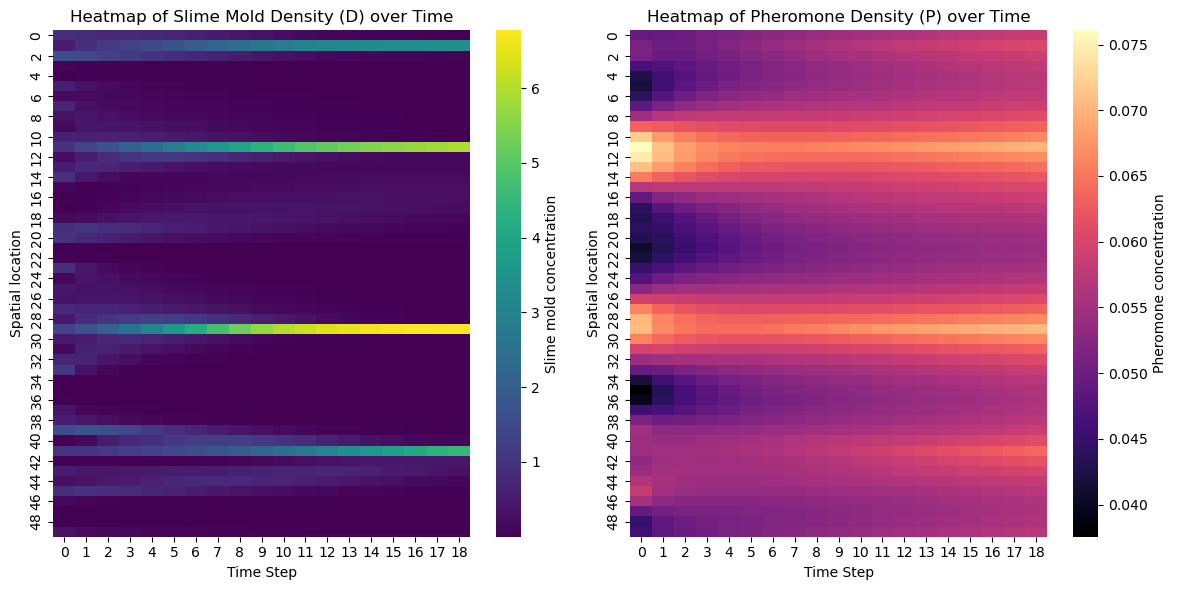

In [117]:
# Simulate the model

# Set parameters
B = torch.tensor(50)
alpha = torch.tensor(.1)
beta_diffuse = torch.tensor(80)
beta_dissipate = torch.tensor(.5)
r = torch.tensor(600)

# Set up the model
certain_model = SimpleSlimeDynamics(B, alpha, beta_diffuse, beta_dissipate, r)
    
# Set up the initial state
with pyro.plate("bins", B):
    D_initial = pyro.sample("D_initial", pyro.distributions.Uniform(0, 1))
    P_initial = pyro.sample("P_initial", pyro.distributions.Uniform(0, .1))

    # # put an abundance of pheromones on the right
    # P_initial = torch.where(torch.arange(B) > B/2, P_initial * 100, P_initial)
    # # put an abundance of slime on the left
    # D_initial = torch.where(torch.arange(B) < B/2, D_initial * 100, D_initial)
initial_state = State(D=D_initial, P=P_initial)

# Set up the trajectory
start_time = torch.tensor(0.0)
end_time = torch.tensor(20.0)
step_size = torch.tensor(1)
trajectory_times = torch.arange(start_time+step_size, end_time, step_size)

# Simulate the model 
with LogTrajectory(trajectory_times) as certain_lt:
    final_state = simulate(certain_model, initial_state, start_time, end_time, solver=TorchDiffEq())
certain_trajectory = certain_lt.trajectory # we're calling it 'certain' because we're certain about the parameters (next step, we'll add uncertainty)

# Plot the results
show_trajectories(certain_trajectory["D"], certain_trajectory["P"]) # Notice how the slime mold forms clumps

## Bayesian slime mold model, for when you don't know the parameters
Add uncertainty over the model parameters and initial conditions

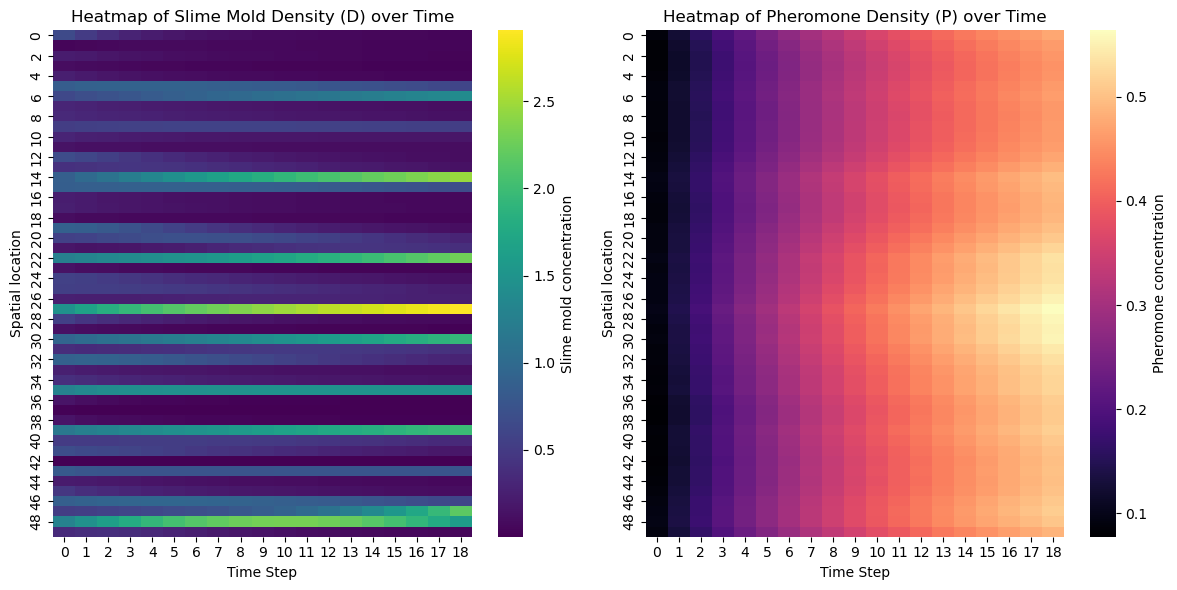

In [118]:
# Define the Bayesian model
class BayesianSimpleSlimeSimulator(pyro.nn.PyroModule):
    def __init__(self, B, noise_sigma):
        super().__init__() 
        self.B = B
        self.noise_sigma = noise_sigma


    def forward(self, start_time: torch.Tensor, end_time: torch.Tensor) -> State[torch.Tensor]:
        # sample model params from the prior
        alpha = pyro.sample("alpha", pyro.distributions.Uniform(0, 5))
        beta_diffuse = pyro.sample("beta_diffuse", pyro.distributions.Uniform(0, 1000))
        beta_dissipate = pyro.sample("beta_dissipate", pyro.distributions.Uniform(0, 5))
        r = pyro.sample("r", pyro.distributions.Uniform(0, 1000))
        model = SimpleSlimeDynamics(self.B, alpha, beta_diffuse, beta_dissipate, r)

        # sample the initial conditions from the prior
        with pyro.plate("bins", B):
            D_initial = pyro.sample("D_initial", pyro.distributions.Uniform(0, 1))
            P_initial = pyro.sample("P_initial", pyro.distributions.Uniform(0, .1))
        initial_state = State(D=D_initial, P=P_initial)

        # simulate the model
        return simulate(model, initial_state, start_time, end_time, solver=TorchDiffEq())

# Simulate a random trajectory from a random model
uncertain_model = BayesianSimpleSlimeSimulator(B, noise_sigma=0.01)

with LogTrajectory(trajectory_times) as uncertain_lt:
    final_state = uncertain_model(start_time, end_time)
uncertain_trajectory = uncertain_lt.trajectory # we're calling it 'uncertain' because we're uncertain about the parameters

# Plot the results
show_trajectories(uncertain_trajectory["D"], uncertain_trajectory["P"]) # Run a few times, notice how different it looks each time, since the parameters are different each time

## Use ChiRho to infer model parameters
First, we'll simulate some data from known parameters. In the simulated experiment, we measure the D and P at times 1 and 19, and there's some measurement noise.

Next, we'll use this data to condition the model. We'll infer the posterior distribution with SVI (stochastic variational inference), and check if this matches the true parameters.

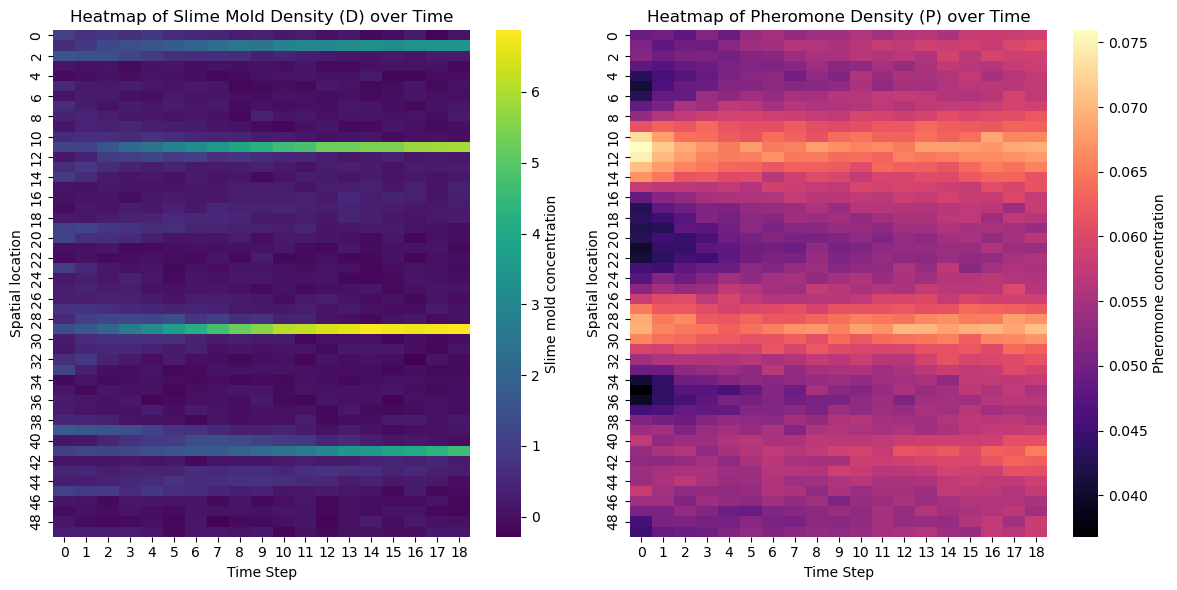

In [124]:
# Define the measurement model: there's some noise in the measurements
class MeasureSlime(pyro.nn.PyroModule):
    def __init__(self, noise_sigma):
        super().__init__()
        self.noise_sigma = noise_sigma # the standard deviation of the measurement noise

    def forward(self, state: State[torch.Tensor]) -> None:
        pyro.sample("observed_D", pyro.distributions.Normal(state["D"], self.noise_sigma).to_event(2)) # to_event(2) means that the distribution is over the last two dimensions, which are space and time
        pyro.sample("observed_P", pyro.distributions.Normal(state["P"], self.noise_sigma/100).to_event(2))

# make synthetic data, by adding measurement noise to the (certain, not Bayesian) trajectory
noise_sigma = torch.tensor(0.1)
measure_slime = MeasureSlime(noise_sigma)
measured_trajectory = State(**{k:v.squeeze() for k, v in pyro.infer.Predictive(measure_slime, num_samples=1)(certain_trajectory).items()})
show_trajectories(measured_trajectory["observed_D"], measured_trajectory["observed_P"])

# restrict measurement to just time 1 and time 19
np.shape(measured_trajectory["observed_D"])
measurement_times_snapshots = trajectory_times[[0, 18]]
measured_trajectory_snapshots = measured_trajectory.copy()
measured_trajectory_snapshots["observed_D"] = measured_trajectory_snapshots["observed_D"][:, [0, 18]]
measured_trajectory_snapshots["observed_P"] = measured_trajectory_snapshots["observed_P"][:, [0, 18]]

In [129]:
# use ChiRho to infer the parameters of the model, conditioned on the measurements

# A function to condition the model on the measurements 
def conditioned_simulation(start_time, end_time, measurement_times, measured_trajectory): # TODO: suppose we only have measurements at certain times, not all times
    obs = condition(data=measured_trajectory)(measure_slime)
    with StaticBatchObservation(measurement_times, observation=obs): 
        uncertain_model(start_time, end_time)

# Define a helper function to run SVI. 
def run_svi_inference(model, n_steps=500, verbose=True, lr=.02, vi_family=AutoMultivariateNormal, guide=None, **model_kwargs):
    if guide is None:
        guide = vi_family(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, n_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 10 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide

# Run SVI 
guide = run_svi_inference(conditioned_simulation, start_time=start_time, end_time=end_time, measurement_times=measurement_times_snapshots, measured_trajectory=measured_trajectory_snapshots)
# Note: guide() is a random function that contains the posterior distribution on inferred parameters. Predictive uses these to sample the trajectory. 


[iteration 0001] loss: 3762.5432
[iteration 0010] loss: 3714.7107
[iteration 0020] loss: 3531.3638
[iteration 0030] loss: 3403.1826
[iteration 0040] loss: 1039.6041
[iteration 0050] loss: 3254.1792
[iteration 0060] loss: 878.7326
[iteration 0070] loss: 805.3286
[iteration 0080] loss: 841.8149
[iteration 0090] loss: 760.7443
[iteration 0100] loss: 682.8114
[iteration 0110] loss: 654.6840
[iteration 0120] loss: 705.2939
[iteration 0130] loss: 573.1598
[iteration 0140] loss: 602.7696
[iteration 0150] loss: 566.7739
[iteration 0160] loss: 466.0521
[iteration 0170] loss: 615.7338
[iteration 0180] loss: 409.0757
[iteration 0190] loss: 510.9975
[iteration 0200] loss: 419.4773
[iteration 0210] loss: 305.3567
[iteration 0220] loss: 283.9821
[iteration 0230] loss: 428.5620
[iteration 0240] loss: 257.4896
[iteration 0250] loss: 252.7767
[iteration 0260] loss: 327.0881
[iteration 0270] loss: 240.5458
[iteration 0280] loss: 356.4518
[iteration 0290] loss: 283.9004
[iteration 0300] loss: 268.8519
[i

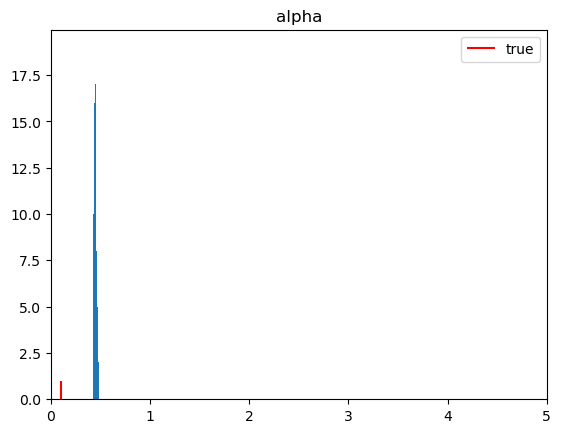

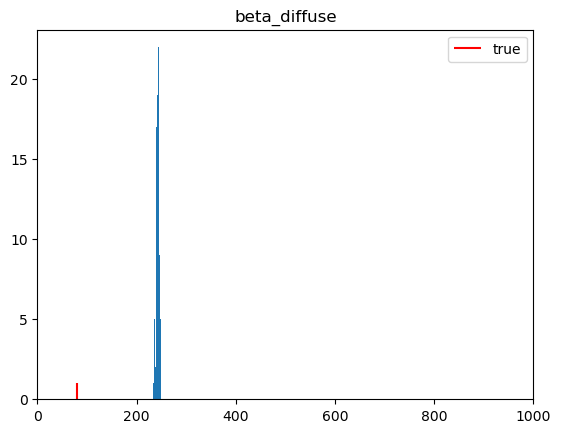

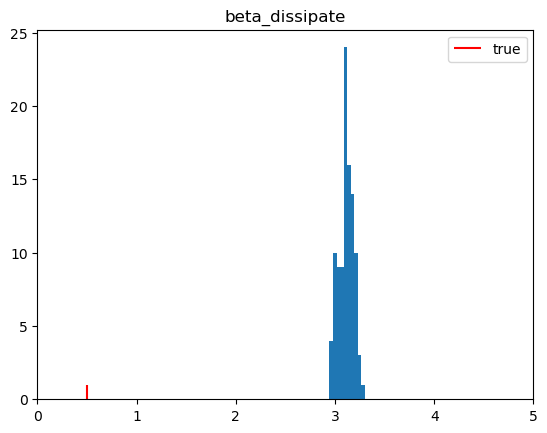

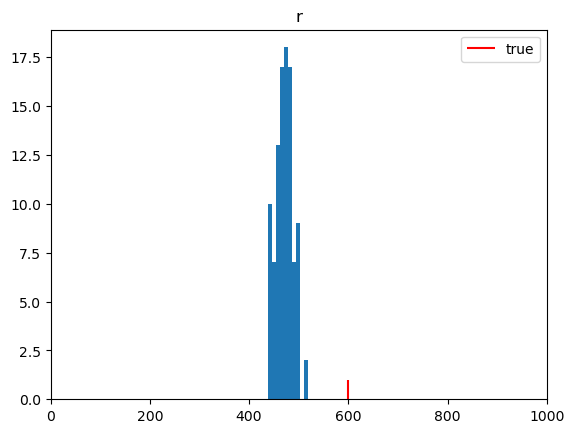

In [130]:
# Check if true params match inferred posterior dist of params

# a function to allow us to get the results of the simulation in the pyro trace, and accessible from the posterior predictive.
def uncertain_model_trajectory(start_time, end_time, measurement_times):
    with LogTrajectory(measurement_times) as lt:
        uncertain_model(start_time, end_time)
    trajectory = lt.trajectory
    [pyro.deterministic(k, v) for k, v in trajectory.items()]

# Sample from the posterior
predictions = pyro.infer.Predictive(uncertain_model_trajectory, guide=guide, num_samples=100)(start_time, end_time, trajectory_times)

# Plot the results
true_params = {"alpha": alpha, "beta_diffuse": beta_diffuse, "beta_dissipate": beta_dissipate, "r": r}
prior_param_ranges = {"alpha": [0, 5], "beta_diffuse": [0, 1000], "beta_dissipate": [0, 5], "r": [0, 1000]}

for param in true_params:
    # show a histogram of the inferred values
    plt.figure()
    plt.title(param)
    plt.hist(predictions[param].detach().numpy().squeeze())
    plt.vlines(true_params[param], ymin=0,ymax=1, color="red", label="true")
    plt.xlim(prior_param_ranges[param])
    plt.legend()



## Use ChiRho to infer what would happen if we intervened
Given our observations from t = 0 and 19, and parameters inferred from this, what would happen to the pheromones if all the slime died at timepoint 10?

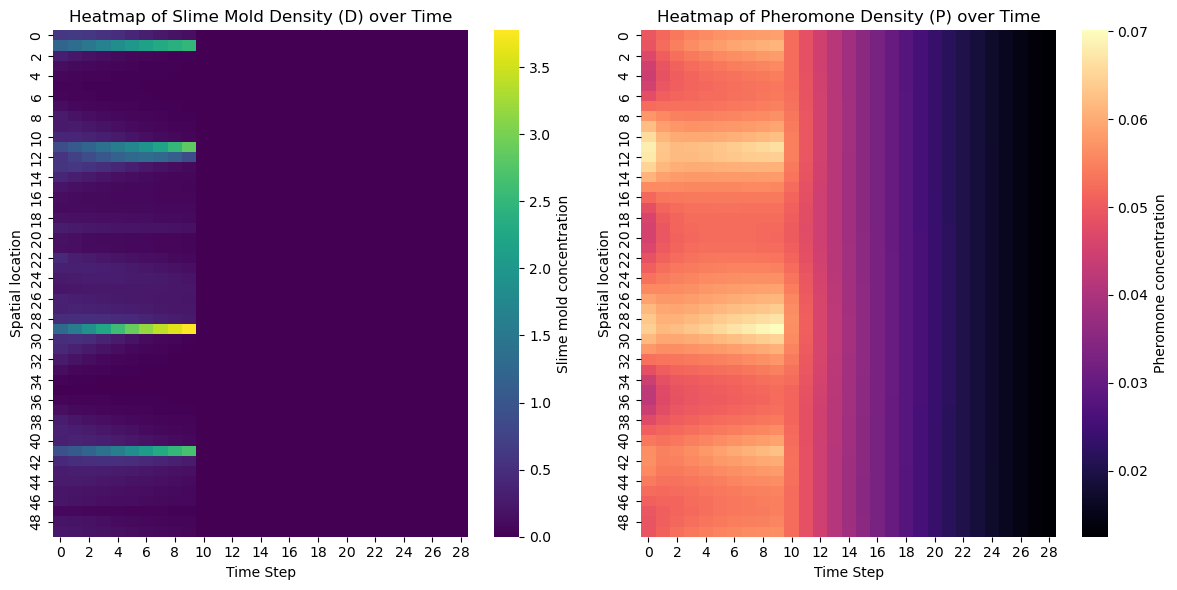

In [128]:
# define an intervened model
def intervened_uncertain_model_trajectory(start_time, end_time, measurement_times, intervene_time: torch.Tensor, intervene_state: State[torch.Tensor]):
    with InterruptionEventLoop():
        with StaticIntervention(intervene_time, intervene_state):
            uncertain_model_trajectory(start_time, end_time, measurement_times)

# intervened predictions. Note: we can use the same guide that we already fit. 
# Set up the trajectory
start_time_for_intervened = torch.tensor(0.0)
end_time_for_intervened = torch.tensor(30.0)
step_size_for_intervened = torch.tensor(1)
trajectory_times_for_intervened = torch.arange(start_time_for_intervened+step_size_for_intervened, end_time_for_intervened, step_size_for_intervened)
intervene_time = torch.tensor(10.0)
intervene_state = State(D=torch.zeros(B)) # intervene by killing all slime, leave pheromone alone. Alternatively, we could intervene by cleaning all pheromone, leaving slime
intervened_predictions = pyro.infer.Predictive(intervened_uncertain_model_trajectory, guide=guide, num_samples=1)(start_time_for_intervened, end_time_for_intervened, trajectory_times_for_intervened, intervene_time, intervene_state)
intervened_trajectory_D = intervened_predictions["D"].squeeze() # predictive returns a collection of predictions
intervened_trajectory_P = intervened_predictions["P"].squeeze()
show_trajectories(intervened_trajectory_D, intervened_trajectory_P) # notice how the slime mold is still clumped, but the pheromones are gone